<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/forwardModels/neuralRepresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Representation
## David Brady
## University of Arizona
## September 2023

### libraries

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu, elu, sigmoid, swish, relu
from tensorflow.keras.backend import get_value
import matplotlib.pyplot as plt
#from google.colab import files
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.special import j0
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size']= 16

2023-09-25 16:50:17.072172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 16:50:17.118147: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Activation functions and peceptrons

  A perceptron operates on a data array $\bf f$ according to $g=o({\bf w}\cdot{\bf f}+b)$, where $o(\cdot )$ is the activation function, ${\bf w}$ is a weight vector and $b$ is a bias value. In typical neural models, the activation function acts as threshold returning positive values above the threshold and zero below threshold. But activation functions may alternatively serve to return frequency or local responses as illustrated by the $\sin(x)$ and Bessel $j0(x)$ functions shown below.

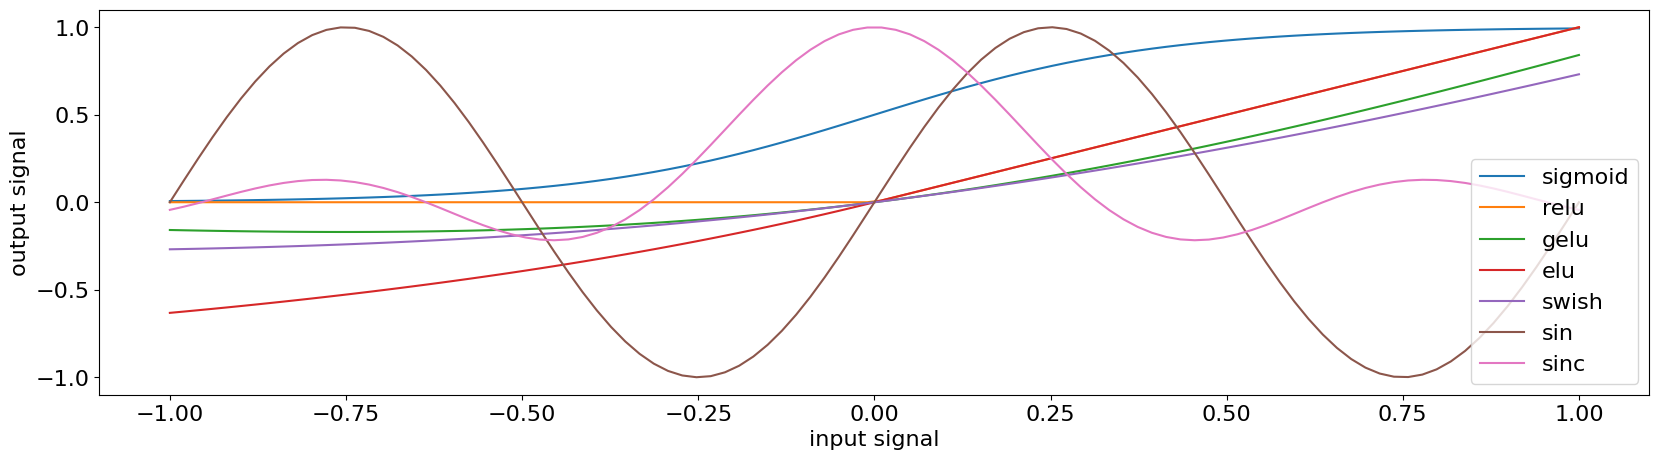

In [ ]:
#
# relu, sigmoid and softmax optimization functions
#
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams.update({'font.size': 16})
x=np.linspace(-1,1,100)
plt.plot(x,sigmoid(5*x),label='sigmoid')
plt.plot(x,relu(x),label='relu')
plt.plot(x,gelu(x),label='gelu')
plt.plot(x,elu(x),label='elu')
plt.plot(x,swish(x),label='swish')
plt.plot(x,np.sin(2*np.pi*x),label='sin')
plt.plot(x,np.sinc(np.pi*x),label='sinc')
plt.xlabel('input signal')
plt.ylabel('output signal')
plt.legend()
plt.savefig('activation.pdf')
#files.download('activation.pdf')

For ${\bf f}\in \mathbb{R}^2$, the  perceptron separates the 2D plane with a line. Here we suppose for example that
 $${\bf w}=\begin{bmatrix}0.5\\0.25\end{bmatrix}$$
 and $b=0.2$

In [ ]:
def grelu(x,y, w, b):
    gv=get_value(relu([w[0]*x+w[1]*y+b]))
    return gv
def ggelu(x,y, w, b):
    gv=get_value(gelu([w[0]*x+w[1]*y+b]))
    return gv
def gsigmoid(x,y, w, b):
    gv=get_value(sigmoid([w[0]*x+w[1]*y+b]))
    return gv
def gsin(x,y, w, b):
    gv=np.sin(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gj0(x,y, w, b):
    gv=j0(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gSinc(x,y, w, b):
    gv=tf.experimental.numpy.sinc(np.pi*(w[0]*x+w[1]*y+b))
    return gv


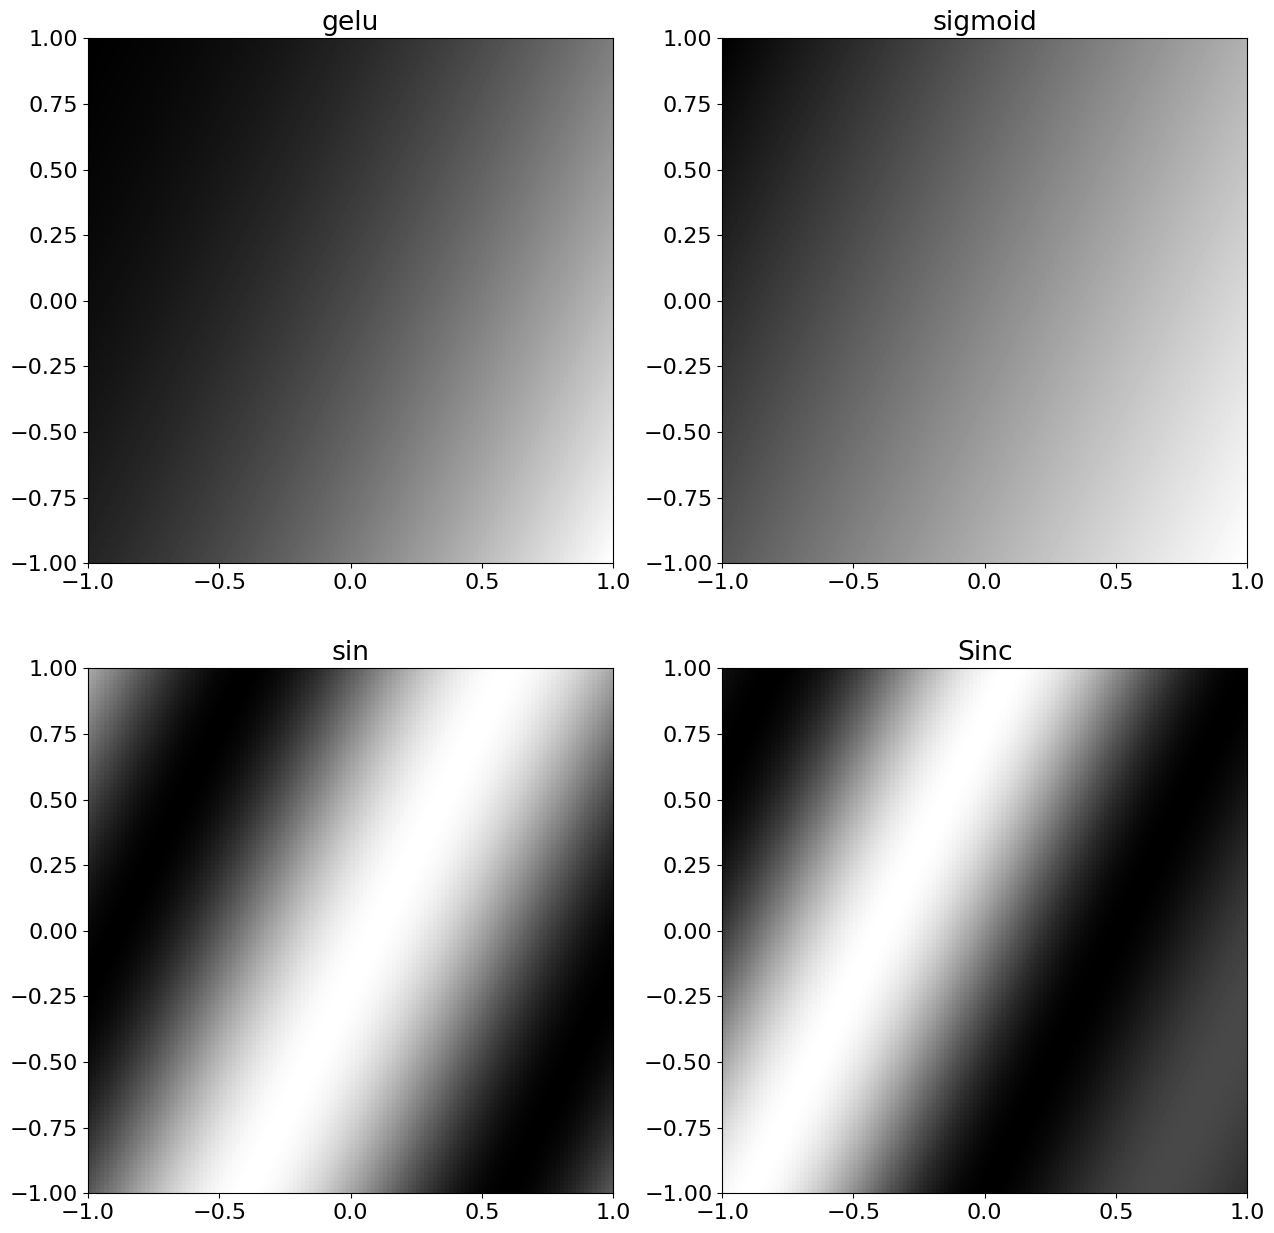

In [ ]:
xRange=np.linspace(-1,1,128)
x,y=np.meshgrid(xRange,xRange)
w=[0.5,0.25]
b=0.2
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
pop=ggelu(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('gelu')
plt.subplot(2,2,2)
pop=gsigmoid(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sigmoid')
plt.subplot(2,2,3)
pop=gsin(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
pop=gSinc(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('Sinc')
plt.savefig('2nodeSegmentation.pdf')

## Multilayer Perceptrons

A multilayer perceptron is a feedforward neural network  with an input layer, hidden layers and an output layer. MLP can be trained to implement arbitrary mappings between the input and output layers.

In [ ]:
coords=tf.stack((x,y))
coords=tf.reshape(coords,[2,-1])
coords=tf.transpose(coords)

In [ ]:
3*256+17*256+17*8+8*2

5272

In [ ]:
128*128

16384

In [ ]:
inputs=layers.Input(shape=( 2))
initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=15)
x1S=layers.Dense(256, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(inputs)
x2S=layers.Dense(16, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x1S)
x3S=layers.Dense(8, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x2S)
x4S=layers.Dense(1, activation=tf.math.sin,kernel_initializer=initializer,trainable=False)(x3S)
mlpSin=Model(inputs,x4S)
x1G=layers.Dense(256, activation='gelu',kernel_initializer=initializer, trainable=False)(inputs)
x2G=layers.Dense(16, activation='gelu',kernel_initializer=initializer, trainable=False)(x1G)
x3G=layers.Dense(8, activation='gelu',kernel_initializer=initializer,trainable=False)(x2G)
x4G=layers.Dense(1, activation='gelu',kernel_initializer=initializer,trainable=False)(x3G)
mlpG=Model(inputs,x4G)
x1J=layers.Dense(256, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(inputs)
x2J=layers.Dense(16, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(x1J)
x3J=layers.Dense(8, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x2J)
x4J=layers.Dense(1, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x3J)
mlpJ=Model(inputs,x4J)


In [ ]:
mlpSimage=mlpSin.predict(coords)
mlpGimage=mlpG.predict(coords)
mlpJimage=mlpJ.predict(coords)

512/512 [==============================] - 0s 377us/step


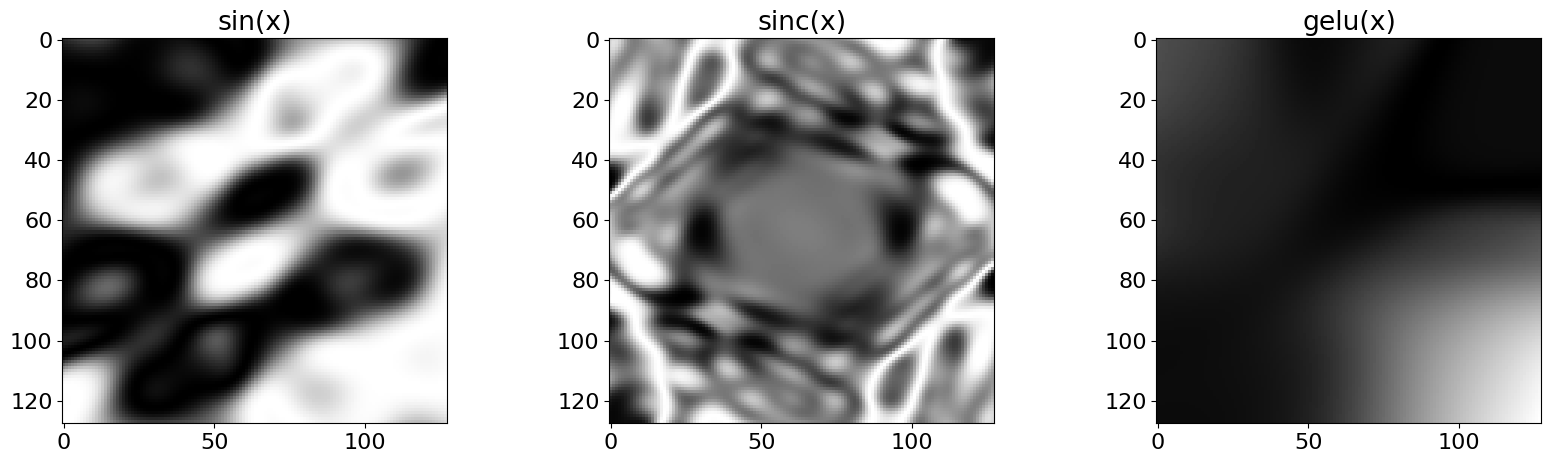

In [ ]:
plt.subplot(1,3,1)
plt.imshow(np.resize(mlpSimage,(128,128)),cmap='gray')
plt.title('sin(x)')
plt.subplot(1,3,2)
plt.imshow(np.resize(mlpJimage,(128,128)), cmap='gray')
plt.title('sinc(x)')
plt.subplot(1,3,3)
plt.imshow(np.resize(mlpGimage,(128,128)), cmap='gray')
plt.title('gelu(x)')
plt.savefig('mlpRandom.pdf')

## Learned neural representation

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()



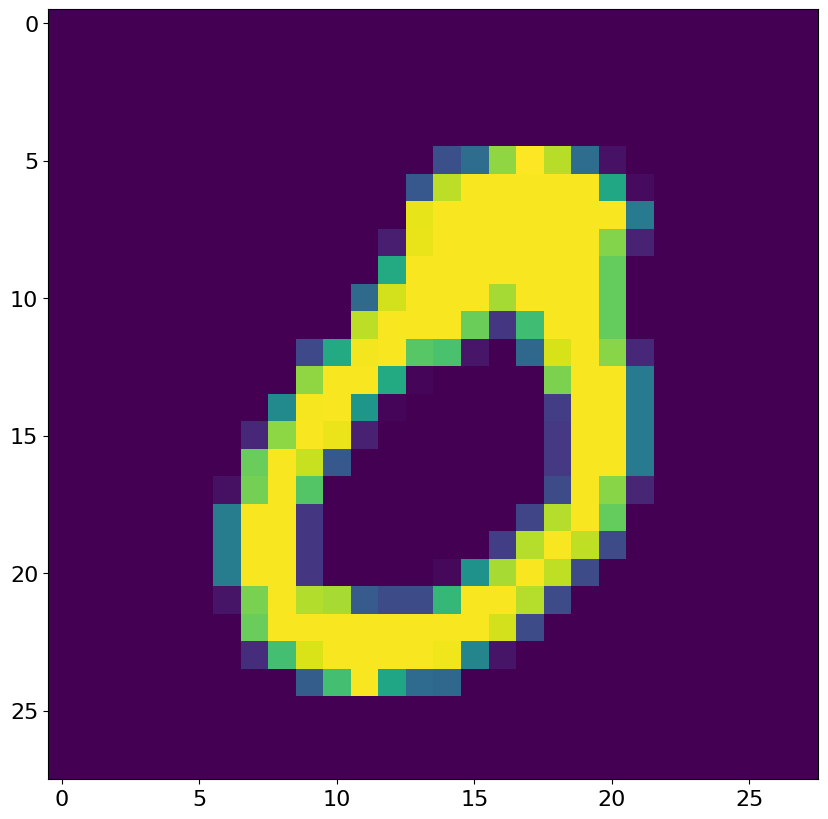

In [ ]:
plt.imshow(x_train[75])


In [ ]:
np.max(x_train[75,:,:])

255

In [ ]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [np.linspace(-1, 1, sidelen)])
    mgrid = np.stack(np.meshgrid(*tensors), -1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

pixels=x_train[75,:,:]/255.
coords = get_mgrid(pixels.shape[0], 2)
pixels=pixels.reshape(28*28,1)
coords= coords.reshape(28*28,2)

train_dataset = tf.data.Dataset.from_tensor_slices(( coords, pixels))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
upCoords=get_mgrid(256, 2)

## Siren

In [ ]:

inputs=layers.Input(shape=( 2))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.math.sin)(inputs)
x2=layers.Dense(4, activation=tf.math.sin)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 16)                48        
                                                                 
 dense_20 (Dense)            (None, 4)                 68        
                                                                 
 dense_21 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp.fit(train_dataset, epochs=1000)


Epoch 1/1000
25/25 [==============================] - 0s 794us/step - loss: 0.2281 - accuracy: 0.4209
Epoch 2/1000
25/25 [==============================] - 0s 782us/step - loss: 0.1984 - accuracy: 0.5587
Epoch 3/1000
25/25 [==============================] - 0s 852us/step - loss: 0.1760 - accuracy: 0.7194
Epoch 4/1000
25/25 [==============================] - 0s 841us/step - loss: 0.1573 - accuracy: 0.7628
Epoch 5/1000
25/25 [==============================] - 0s 739us/step - loss: 0.1435 - accuracy: 0.7628
Epoch 6/1000
25/25 [==============================] - 0s 807us/step - loss: 0.1342 - accuracy: 0.7628
Epoch 7/1000
25/25 [==============================] - 0s 735us/step - loss: 0.1286 - accuracy: 0.7628
Epoch 8/1000
25/25 [==============================] - 0s 740us/step - loss: 0.1254 - accuracy: 0.7628
Epoch 9/1000
25/25 [==============================] - 0s 768us/step - loss: 0.1236 - accuracy: 0.7628
Epoch 10/1000
25/25 [==============================] - 0s 801us/step - loss: 0.122

25/25 [==============================] - 0s 806us/step - loss: 0.1208 - accuracy: 0.7628
Epoch 81/1000
25/25 [==============================] - 0s 720us/step - loss: 0.1207 - accuracy: 0.7628
Epoch 82/1000
25/25 [==============================] - 0s 760us/step - loss: 0.1209 - accuracy: 0.7628
Epoch 83/1000
25/25 [==============================] - 0s 741us/step - loss: 0.1207 - accuracy: 0.7628
Epoch 84/1000
25/25 [==============================] - 0s 813us/step - loss: 0.1208 - accuracy: 0.7628
Epoch 85/1000
25/25 [==============================] - 0s 968us/step - loss: 0.1208 - accuracy: 0.7628
Epoch 86/1000
25/25 [==============================] - 0s 753us/step - loss: 0.1207 - accuracy: 0.7628
Epoch 87/1000
25/25 [==============================] - 0s 817us/step - loss: 0.1208 - accuracy: 0.7628
Epoch 88/1000
25/25 [==============================] - 0s 832us/step - loss: 0.1207 - accuracy: 0.7628
Epoch 89/1000
25/25 [==============================] - 0s 763us/step - loss: 0.1208 - a

25/25 [==============================] - 0s 832us/step - loss: 0.1206 - accuracy: 0.7628
Epoch 160/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.1205 - accuracy: 0.7628
Epoch 161/1000
25/25 [==============================] - 0s 851us/step - loss: 0.1205 - accuracy: 0.7628
Epoch 162/1000
25/25 [==============================] - 0s 764us/step - loss: 0.1205 - accuracy: 0.7628
Epoch 163/1000
25/25 [==============================] - 0s 833us/step - loss: 0.1206 - accuracy: 0.7628
Epoch 164/1000
25/25 [==============================] - 0s 846us/step - loss: 0.1204 - accuracy: 0.7628
Epoch 165/1000
25/25 [==============================] - 0s 817us/step - loss: 0.1206 - accuracy: 0.7628
Epoch 166/1000
25/25 [==============================] - 0s 731us/step - loss: 0.1204 - accuracy: 0.7628
Epoch 167/1000
25/25 [==============================] - 0s 998us/step - loss: 0.1204 - accuracy: 0.7628
Epoch 168/1000
25/25 [==============================] - 0s 809us/step - loss: 0.1

Epoch 238/1000
25/25 [==============================] - 0s 792us/step - loss: 0.1005 - accuracy: 0.7628
Epoch 239/1000
25/25 [==============================] - 0s 800us/step - loss: 0.1002 - accuracy: 0.7628
Epoch 240/1000
25/25 [==============================] - 0s 753us/step - loss: 0.0997 - accuracy: 0.7628
Epoch 241/1000
25/25 [==============================] - 0s 732us/step - loss: 0.0990 - accuracy: 0.7628
Epoch 242/1000
25/25 [==============================] - 0s 855us/step - loss: 0.0993 - accuracy: 0.7628
Epoch 243/1000
25/25 [==============================] - 0s 739us/step - loss: 0.0984 - accuracy: 0.7628
Epoch 244/1000
25/25 [==============================] - 0s 972us/step - loss: 0.0985 - accuracy: 0.7628
Epoch 245/1000
25/25 [==============================] - 0s 745us/step - loss: 0.0983 - accuracy: 0.7628
Epoch 246/1000
25/25 [==============================] - 0s 705us/step - loss: 0.0978 - accuracy: 0.7628
Epoch 247/1000
25/25 [==============================] - 0s 739us

25/25 [==============================] - 0s 756us/step - loss: 0.0953 - accuracy: 0.7628
Epoch 317/1000
25/25 [==============================] - 0s 705us/step - loss: 0.0954 - accuracy: 0.7628
Epoch 318/1000
25/25 [==============================] - 0s 708us/step - loss: 0.0954 - accuracy: 0.7628
Epoch 319/1000
25/25 [==============================] - 0s 781us/step - loss: 0.0951 - accuracy: 0.7628
Epoch 320/1000
25/25 [==============================] - 0s 758us/step - loss: 0.0952 - accuracy: 0.7628
Epoch 321/1000
25/25 [==============================] - 0s 861us/step - loss: 0.0955 - accuracy: 0.7628
Epoch 322/1000
25/25 [==============================] - 0s 730us/step - loss: 0.0953 - accuracy: 0.7628
Epoch 323/1000
25/25 [==============================] - 0s 807us/step - loss: 0.0951 - accuracy: 0.7628
Epoch 324/1000
25/25 [==============================] - 0s 688us/step - loss: 0.0951 - accuracy: 0.7628
Epoch 325/1000
25/25 [==============================] - 0s 694us/step - loss: 0

25/25 [==============================] - 0s 718us/step - loss: 0.0817 - accuracy: 0.7270
Epoch 395/1000
25/25 [==============================] - 0s 740us/step - loss: 0.0813 - accuracy: 0.7283
Epoch 396/1000
25/25 [==============================] - 0s 700us/step - loss: 0.0811 - accuracy: 0.7296
Epoch 397/1000
25/25 [==============================] - 0s 785us/step - loss: 0.0810 - accuracy: 0.7296
Epoch 398/1000
25/25 [==============================] - 0s 718us/step - loss: 0.0808 - accuracy: 0.7309
Epoch 399/1000
25/25 [==============================] - 0s 853us/step - loss: 0.0807 - accuracy: 0.7296
Epoch 400/1000
25/25 [==============================] - 0s 816us/step - loss: 0.0805 - accuracy: 0.7296
Epoch 401/1000
25/25 [==============================] - 0s 744us/step - loss: 0.0802 - accuracy: 0.7296
Epoch 402/1000
25/25 [==============================] - 0s 885us/step - loss: 0.0801 - accuracy: 0.7270
Epoch 403/1000
25/25 [==============================] - 0s 919us/step - loss: 0

Epoch 473/1000
25/25 [==============================] - 0s 870us/step - loss: 0.0694 - accuracy: 0.7436
Epoch 474/1000
25/25 [==============================] - 0s 953us/step - loss: 0.0691 - accuracy: 0.7449
Epoch 475/1000
25/25 [==============================] - 0s 823us/step - loss: 0.0692 - accuracy: 0.7436
Epoch 476/1000
25/25 [==============================] - 0s 816us/step - loss: 0.0688 - accuracy: 0.7436
Epoch 477/1000
25/25 [==============================] - 0s 782us/step - loss: 0.0685 - accuracy: 0.7436
Epoch 478/1000
25/25 [==============================] - 0s 730us/step - loss: 0.0684 - accuracy: 0.7449
Epoch 479/1000
25/25 [==============================] - 0s 821us/step - loss: 0.0684 - accuracy: 0.7449
Epoch 480/1000
25/25 [==============================] - 0s 840us/step - loss: 0.0680 - accuracy: 0.7436
Epoch 481/1000
25/25 [==============================] - 0s 759us/step - loss: 0.0679 - accuracy: 0.7449
Epoch 482/1000
25/25 [==============================] - 0s 854us

25/25 [==============================] - 0s 671us/step - loss: 0.0521 - accuracy: 0.7615
Epoch 552/1000
25/25 [==============================] - 0s 891us/step - loss: 0.0518 - accuracy: 0.7615
Epoch 553/1000
25/25 [==============================] - 0s 847us/step - loss: 0.0515 - accuracy: 0.7615
Epoch 554/1000
25/25 [==============================] - 0s 812us/step - loss: 0.0511 - accuracy: 0.7602
Epoch 555/1000
25/25 [==============================] - 0s 738us/step - loss: 0.0509 - accuracy: 0.7615
Epoch 556/1000
25/25 [==============================] - 0s 793us/step - loss: 0.0507 - accuracy: 0.7602
Epoch 557/1000
25/25 [==============================] - 0s 829us/step - loss: 0.0503 - accuracy: 0.7602
Epoch 558/1000
25/25 [==============================] - 0s 847us/step - loss: 0.0501 - accuracy: 0.7602
Epoch 559/1000
25/25 [==============================] - 0s 786us/step - loss: 0.0499 - accuracy: 0.7602
Epoch 560/1000
25/25 [==============================] - 0s 813us/step - loss: 0

Epoch 630/1000
25/25 [==============================] - 0s 842us/step - loss: 0.0353 - accuracy: 0.7628
Epoch 631/1000
25/25 [==============================] - 0s 736us/step - loss: 0.0350 - accuracy: 0.7628
Epoch 632/1000
25/25 [==============================] - 0s 847us/step - loss: 0.0349 - accuracy: 0.7628
Epoch 633/1000
25/25 [==============================] - 0s 767us/step - loss: 0.0348 - accuracy: 0.7628
Epoch 634/1000
25/25 [==============================] - 0s 733us/step - loss: 0.0347 - accuracy: 0.7628
Epoch 635/1000
25/25 [==============================] - 0s 754us/step - loss: 0.0345 - accuracy: 0.7628
Epoch 636/1000
25/25 [==============================] - 0s 796us/step - loss: 0.0345 - accuracy: 0.7628
Epoch 637/1000
25/25 [==============================] - 0s 787us/step - loss: 0.0344 - accuracy: 0.7628
Epoch 638/1000
25/25 [==============================] - 0s 776us/step - loss: 0.0342 - accuracy: 0.7628
Epoch 639/1000
25/25 [==============================] - 0s 784us

25/25 [==============================] - 0s 787us/step - loss: 0.0259 - accuracy: 0.7628
Epoch 709/1000
25/25 [==============================] - 0s 783us/step - loss: 0.0257 - accuracy: 0.7628
Epoch 710/1000
25/25 [==============================] - 0s 902us/step - loss: 0.0257 - accuracy: 0.7615
Epoch 711/1000
25/25 [==============================] - 0s 729us/step - loss: 0.0255 - accuracy: 0.7615
Epoch 712/1000
25/25 [==============================] - 0s 754us/step - loss: 0.0254 - accuracy: 0.7615
Epoch 713/1000
25/25 [==============================] - 0s 871us/step - loss: 0.0253 - accuracy: 0.7615
Epoch 714/1000
25/25 [==============================] - 0s 985us/step - loss: 0.0251 - accuracy: 0.7615
Epoch 715/1000
25/25 [==============================] - 0s 808us/step - loss: 0.0249 - accuracy: 0.7615
Epoch 716/1000
25/25 [==============================] - 0s 773us/step - loss: 0.0250 - accuracy: 0.7615
Epoch 717/1000
25/25 [==============================] - 0s 913us/step - loss: 0

Epoch 787/1000
25/25 [==============================] - 0s 762us/step - loss: 0.0173 - accuracy: 0.7640
Epoch 788/1000
25/25 [==============================] - 0s 766us/step - loss: 0.0172 - accuracy: 0.7640
Epoch 789/1000
25/25 [==============================] - 0s 723us/step - loss: 0.0171 - accuracy: 0.7640
Epoch 790/1000
25/25 [==============================] - 0s 763us/step - loss: 0.0170 - accuracy: 0.7640
Epoch 791/1000
25/25 [==============================] - 0s 672us/step - loss: 0.0170 - accuracy: 0.7640
Epoch 792/1000
25/25 [==============================] - 0s 772us/step - loss: 0.0169 - accuracy: 0.7640
Epoch 793/1000
25/25 [==============================] - 0s 687us/step - loss: 0.0168 - accuracy: 0.7640
Epoch 794/1000
25/25 [==============================] - 0s 773us/step - loss: 0.0167 - accuracy: 0.7640
Epoch 795/1000
25/25 [==============================] - 0s 761us/step - loss: 0.0166 - accuracy: 0.7640
Epoch 796/1000
25/25 [==============================] - 0s 806us

25/25 [==============================] - 0s 717us/step - loss: 0.0118 - accuracy: 0.7640
Epoch 866/1000
25/25 [==============================] - 0s 871us/step - loss: 0.0118 - accuracy: 0.7628
Epoch 867/1000
25/25 [==============================] - 0s 773us/step - loss: 0.0117 - accuracy: 0.7640
Epoch 868/1000
25/25 [==============================] - 0s 843us/step - loss: 0.0118 - accuracy: 0.7640
Epoch 869/1000
25/25 [==============================] - 0s 849us/step - loss: 0.0116 - accuracy: 0.7628
Epoch 870/1000
25/25 [==============================] - 0s 850us/step - loss: 0.0116 - accuracy: 0.7640
Epoch 871/1000
25/25 [==============================] - 0s 822us/step - loss: 0.0115 - accuracy: 0.7640
Epoch 872/1000
25/25 [==============================] - 0s 786us/step - loss: 0.0115 - accuracy: 0.7640
Epoch 873/1000
25/25 [==============================] - 0s 761us/step - loss: 0.0115 - accuracy: 0.7640
Epoch 874/1000
25/25 [==============================] - 0s 728us/step - loss: 0

25/25 [==============================] - 0s 694us/step - loss: 0.0097 - accuracy: 0.7640
Epoch 944/1000
25/25 [==============================] - 0s 694us/step - loss: 0.0097 - accuracy: 0.7640
Epoch 945/1000
25/25 [==============================] - 0s 731us/step - loss: 0.0097 - accuracy: 0.7640
Epoch 946/1000
25/25 [==============================] - 0s 780us/step - loss: 0.0096 - accuracy: 0.7640
Epoch 947/1000
25/25 [==============================] - 0s 881us/step - loss: 0.0097 - accuracy: 0.7640
Epoch 948/1000
25/25 [==============================] - 0s 738us/step - loss: 0.0096 - accuracy: 0.7640
Epoch 949/1000
25/25 [==============================] - 0s 698us/step - loss: 0.0096 - accuracy: 0.7640
Epoch 950/1000
25/25 [==============================] - 0s 760us/step - loss: 0.0095 - accuracy: 0.7640
Epoch 951/1000
25/25 [==============================] - 0s 681us/step - loss: 0.0096 - accuracy: 0.7640
Epoch 952/1000
25/25 [==============================] - 0s 819us/step - loss: 0

In [ ]:
pip=mlp.predict(coords)
pipUp=mlp.predict(upCoords)


2048/2048 [==============================] - 1s 375us/step


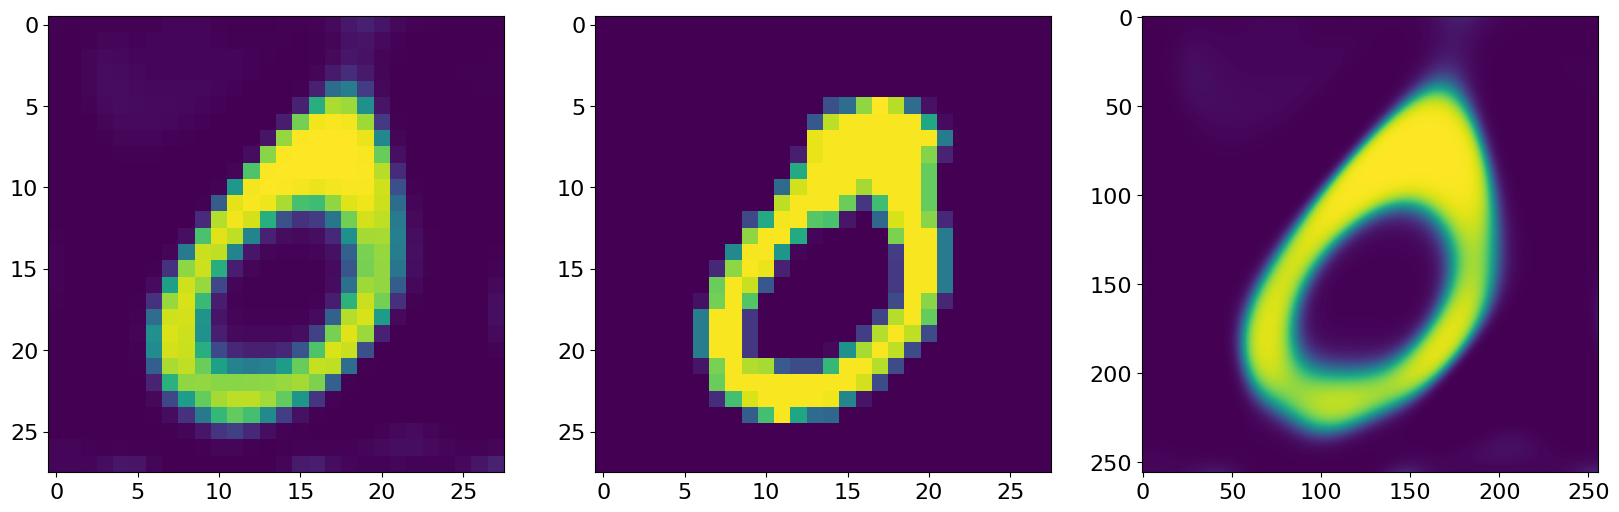

In [ ]:
plt.subplot(1,3,1)
plt.imshow(pip.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(pipUp.reshape((256,256)))





## Sinc

In [ ]:

inputs=layers.Input(shape=( 2))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.experimental.numpy.sinc)(inputs)
x2=layers.Dense(4, activation=tf.experimental.numpy.sinc)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_22 (Dense)            (None, 16)                48        
                                                                 
 dense_23 (Dense)            (None, 4)                 68        
                                                                 
 dense_24 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 0s 898us/step - loss: 0.3522 - accuracy: 0.0013
Epoch 2/1000
25/25 [==============================] - 0s 802us/step - loss: 0.2016 - accuracy: 0.6135
Epoch 3/1000
25/25 [==============================] - 0s 871us/step - loss: 0.1525 - accuracy: 0.7628
Epoch 4/1000
25/25 [==============================] - 0s 828us/step - loss: 0.1404 - accuracy: 0.7628
Epoch 5/1000
25/25 [==============================] - 0s 803us/step - loss: 0.1358 - accuracy: 0.7628
Epoch 6/1000
25/25 [==============================] - 0s 883us/step - loss: 0.1333 - accuracy: 0.7628
Epoch 7/1000
25/25 [==============================] - 0s 907us/step - loss: 0.1313 - accuracy: 0.7628
Epoch 8/1000
25/25 [==============================] - 0s 932us/step - loss: 0.1297 - accuracy: 0.7628
Epoch 9/1000
25/25 [==============================] - 0s 914us/step - loss: 0.1283 - accuracy: 0.7628
Epoch 10/1000
25/25 [==============================] - 0s 949us/step - loss: 0.127

25/25 [==============================] - 0s 861us/step - loss: 0.0590 - accuracy: 0.7602
Epoch 81/1000
25/25 [==============================] - 0s 797us/step - loss: 0.0584 - accuracy: 0.7602
Epoch 82/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0579 - accuracy: 0.7602
Epoch 83/1000
25/25 [==============================] - 0s 738us/step - loss: 0.0571 - accuracy: 0.7602
Epoch 84/1000
25/25 [==============================] - 0s 767us/step - loss: 0.0567 - accuracy: 0.7602
Epoch 85/1000
25/25 [==============================] - 0s 966us/step - loss: 0.0563 - accuracy: 0.7615
Epoch 86/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0557 - accuracy: 0.7602
Epoch 87/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0555 - accuracy: 0.7602
Epoch 88/1000
25/25 [==============================] - 0s 961us/step - loss: 0.0549 - accuracy: 0.7602
Epoch 89/1000
25/25 [==============================] - 0s 870us/step - loss: 0.0546 - accurac

25/25 [==============================] - 0s 894us/step - loss: 0.0340 - accuracy: 0.7589
Epoch 160/1000
25/25 [==============================] - 0s 830us/step - loss: 0.0336 - accuracy: 0.7577
Epoch 161/1000
25/25 [==============================] - 0s 832us/step - loss: 0.0330 - accuracy: 0.7577
Epoch 162/1000
25/25 [==============================] - 0s 831us/step - loss: 0.0332 - accuracy: 0.7577
Epoch 163/1000
25/25 [==============================] - 0s 868us/step - loss: 0.0326 - accuracy: 0.7577
Epoch 164/1000
25/25 [==============================] - 0s 885us/step - loss: 0.0324 - accuracy: 0.7589
Epoch 165/1000
25/25 [==============================] - 0s 908us/step - loss: 0.0323 - accuracy: 0.7577
Epoch 166/1000
25/25 [==============================] - 0s 893us/step - loss: 0.0320 - accuracy: 0.7577
Epoch 167/1000
25/25 [==============================] - 0s 847us/step - loss: 0.0317 - accuracy: 0.7589
Epoch 168/1000
25/25 [==============================] - 0s 885us/step - loss: 0

25/25 [==============================] - 0s 906us/step - loss: 0.0167 - accuracy: 0.7640
Epoch 239/1000
25/25 [==============================] - 0s 911us/step - loss: 0.0167 - accuracy: 0.7640
Epoch 240/1000
25/25 [==============================] - 0s 785us/step - loss: 0.0164 - accuracy: 0.7640
Epoch 241/1000
25/25 [==============================] - 0s 830us/step - loss: 0.0165 - accuracy: 0.7640
Epoch 242/1000
25/25 [==============================] - 0s 853us/step - loss: 0.0162 - accuracy: 0.7640
Epoch 243/1000
25/25 [==============================] - 0s 831us/step - loss: 0.0162 - accuracy: 0.7640
Epoch 244/1000
25/25 [==============================] - 0s 875us/step - loss: 0.0161 - accuracy: 0.7640
Epoch 245/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0158 - accuracy: 0.7640
Epoch 246/1000
25/25 [==============================] - 0s 966us/step - loss: 0.0159 - accuracy: 0.7640
Epoch 247/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.015

25/25 [==============================] - 0s 812us/step - loss: 0.0091 - accuracy: 0.7640
Epoch 318/1000
25/25 [==============================] - 0s 817us/step - loss: 0.0089 - accuracy: 0.7640
Epoch 319/1000
25/25 [==============================] - 0s 933us/step - loss: 0.0090 - accuracy: 0.7640
Epoch 320/1000
25/25 [==============================] - 0s 825us/step - loss: 0.0089 - accuracy: 0.7640
Epoch 321/1000
25/25 [==============================] - 0s 847us/step - loss: 0.0088 - accuracy: 0.7640
Epoch 322/1000
25/25 [==============================] - 0s 772us/step - loss: 0.0088 - accuracy: 0.7640
Epoch 323/1000
25/25 [==============================] - 0s 875us/step - loss: 0.0090 - accuracy: 0.7640
Epoch 324/1000
25/25 [==============================] - 0s 894us/step - loss: 0.0087 - accuracy: 0.7640
Epoch 325/1000
25/25 [==============================] - 0s 782us/step - loss: 0.0086 - accuracy: 0.7640
Epoch 326/1000
25/25 [==============================] - 0s 780us/step - loss: 0

25/25 [==============================] - 0s 941us/step - loss: 0.0062 - accuracy: 0.7640
Epoch 397/1000
25/25 [==============================] - 0s 982us/step - loss: 0.0061 - accuracy: 0.7640
Epoch 398/1000
25/25 [==============================] - 0s 845us/step - loss: 0.0062 - accuracy: 0.7640
Epoch 399/1000
25/25 [==============================] - 0s 903us/step - loss: 0.0061 - accuracy: 0.7640
Epoch 400/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 0.7640
Epoch 401/1000
25/25 [==============================] - 0s 918us/step - loss: 0.0063 - accuracy: 0.7640
Epoch 402/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.7640
Epoch 403/1000
25/25 [==============================] - 0s 854us/step - loss: 0.0058 - accuracy: 0.7640
Epoch 404/1000
25/25 [==============================] - 0s 843us/step - loss: 0.0062 - accuracy: 0.7640
Epoch 405/1000
25/25 [==============================] - 0s 957us/step - loss: 0.006

25/25 [==============================] - 0s 990us/step - loss: 0.0075 - accuracy: 0.7640
Epoch 476/1000
25/25 [==============================] - 0s 967us/step - loss: 0.0069 - accuracy: 0.7628
Epoch 477/1000
25/25 [==============================] - 0s 948us/step - loss: 0.0062 - accuracy: 0.7640
Epoch 478/1000
25/25 [==============================] - 0s 824us/step - loss: 0.0058 - accuracy: 0.7640
Epoch 479/1000
25/25 [==============================] - 0s 891us/step - loss: 0.0058 - accuracy: 0.7640
Epoch 480/1000
25/25 [==============================] - 0s 748us/step - loss: 0.0057 - accuracy: 0.7640
Epoch 481/1000
25/25 [==============================] - 0s 924us/step - loss: 0.0052 - accuracy: 0.7640
Epoch 482/1000
25/25 [==============================] - 0s 949us/step - loss: 0.0062 - accuracy: 0.7628
Epoch 483/1000
25/25 [==============================] - 0s 915us/step - loss: 0.0051 - accuracy: 0.7640
Epoch 484/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0

25/25 [==============================] - 0s 835us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 555/1000
25/25 [==============================] - 0s 890us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 556/1000
25/25 [==============================] - 0s 893us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 557/1000
25/25 [==============================] - 0s 866us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 558/1000
25/25 [==============================] - 0s 857us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 559/1000
25/25 [==============================] - 0s 968us/step - loss: 0.0039 - accuracy: 0.7640
Epoch 560/1000
25/25 [==============================] - 0s 885us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 561/1000
25/25 [==============================] - 0s 832us/step - loss: 0.0043 - accuracy: 0.7640
Epoch 562/1000
25/25 [==============================] - 0s 790us/step - loss: 0.0042 - accuracy: 0.7640
Epoch 563/1000
25/25 [==============================] - 0s 831us/step - loss: 0

Epoch 633/1000
25/25 [==============================] - 0s 783us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 634/1000
25/25 [==============================] - 0s 739us/step - loss: 0.0040 - accuracy: 0.7640
Epoch 635/1000
25/25 [==============================] - 0s 838us/step - loss: 0.0038 - accuracy: 0.7640
Epoch 636/1000
25/25 [==============================] - 0s 873us/step - loss: 0.0039 - accuracy: 0.7640
Epoch 637/1000
25/25 [==============================] - 0s 807us/step - loss: 0.0036 - accuracy: 0.7640
Epoch 638/1000
25/25 [==============================] - 0s 901us/step - loss: 0.0041 - accuracy: 0.7640
Epoch 639/1000
25/25 [==============================] - 0s 769us/step - loss: 0.0037 - accuracy: 0.7640
Epoch 640/1000
25/25 [==============================] - 0s 795us/step - loss: 0.0039 - accuracy: 0.7640
Epoch 641/1000
25/25 [==============================] - 0s 761us/step - loss: 0.0036 - accuracy: 0.7640
Epoch 642/1000
25/25 [==============================] - 0s 1ms/s

25/25 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 0.7640
Epoch 712/1000
25/25 [==============================] - 0s 983us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 713/1000
25/25 [==============================] - 0s 924us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 714/1000
25/25 [==============================] - 0s 995us/step - loss: 0.0038 - accuracy: 0.7640
Epoch 715/1000
25/25 [==============================] - 0s 898us/step - loss: 0.0036 - accuracy: 0.7640
Epoch 716/1000
25/25 [==============================] - 0s 789us/step - loss: 0.0041 - accuracy: 0.7640
Epoch 717/1000
25/25 [==============================] - 0s 950us/step - loss: 0.0039 - accuracy: 0.7640
Epoch 718/1000
25/25 [==============================] - 0s 919us/step - loss: 0.0052 - accuracy: 0.7640
Epoch 719/1000
25/25 [==============================] - 0s 813us/step - loss: 0.0045 - accuracy: 0.7640
Epoch 720/1000
25/25 [==============================] - 0s 758us/step - loss: 0.0

25/25 [==============================] - 0s 752us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 791/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.7640
Epoch 792/1000
25/25 [==============================] - 0s 932us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 793/1000
25/25 [==============================] - 0s 763us/step - loss: 0.0037 - accuracy: 0.7640
Epoch 794/1000
25/25 [==============================] - 0s 818us/step - loss: 0.0033 - accuracy: 0.7640
Epoch 795/1000
25/25 [==============================] - 0s 927us/step - loss: 0.0033 - accuracy: 0.7640
Epoch 796/1000
25/25 [==============================] - 0s 922us/step - loss: 0.0032 - accuracy: 0.7640
Epoch 797/1000
25/25 [==============================] - 0s 929us/step - loss: 0.0031 - accuracy: 0.7640
Epoch 798/1000
25/25 [==============================] - 0s 763us/step - loss: 0.0031 - accuracy: 0.7640
Epoch 799/1000
25/25 [==============================] - 0s 865us/step - loss: 0.0

25/25 [==============================] - 0s 879us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 870/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.7640
Epoch 871/1000
25/25 [==============================] - 0s 941us/step - loss: 0.0033 - accuracy: 0.7640
Epoch 872/1000
25/25 [==============================] - 0s 909us/step - loss: 0.0031 - accuracy: 0.7640
Epoch 873/1000
25/25 [==============================] - 0s 843us/step - loss: 0.0033 - accuracy: 0.7640
Epoch 874/1000
25/25 [==============================] - 0s 758us/step - loss: 0.0033 - accuracy: 0.7640
Epoch 875/1000
25/25 [==============================] - 0s 851us/step - loss: 0.0035 - accuracy: 0.7640
Epoch 876/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.7640
Epoch 877/1000
25/25 [==============================] - 0s 990us/step - loss: 0.0036 - accuracy: 0.7640
Epoch 878/1000
25/25 [==============================] - 0s 866us/step - loss: 0.004

25/25 [==============================] - 0s 840us/step - loss: 0.0032 - accuracy: 0.7640
Epoch 949/1000
25/25 [==============================] - 0s 838us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 950/1000
25/25 [==============================] - 0s 835us/step - loss: 0.0031 - accuracy: 0.7640
Epoch 951/1000
25/25 [==============================] - 0s 821us/step - loss: 0.0034 - accuracy: 0.7640
Epoch 952/1000
25/25 [==============================] - 0s 874us/step - loss: 0.0031 - accuracy: 0.7640
Epoch 953/1000
25/25 [==============================] - 0s 817us/step - loss: 0.0033 - accuracy: 0.7640
Epoch 954/1000
25/25 [==============================] - 0s 722us/step - loss: 0.0032 - accuracy: 0.7640
Epoch 955/1000
25/25 [==============================] - 0s 890us/step - loss: 0.0031 - accuracy: 0.7640
Epoch 956/1000
25/25 [==============================] - 0s 902us/step - loss: 0.0032 - accuracy: 0.7640
Epoch 957/1000
25/25 [==============================] - 0s 763us/step - loss: 0

In [ ]:
pap=mlp.predict(coords)
papUp=mlp.predict(upCoords)

2048/2048 [==============================] - 1s 421us/step


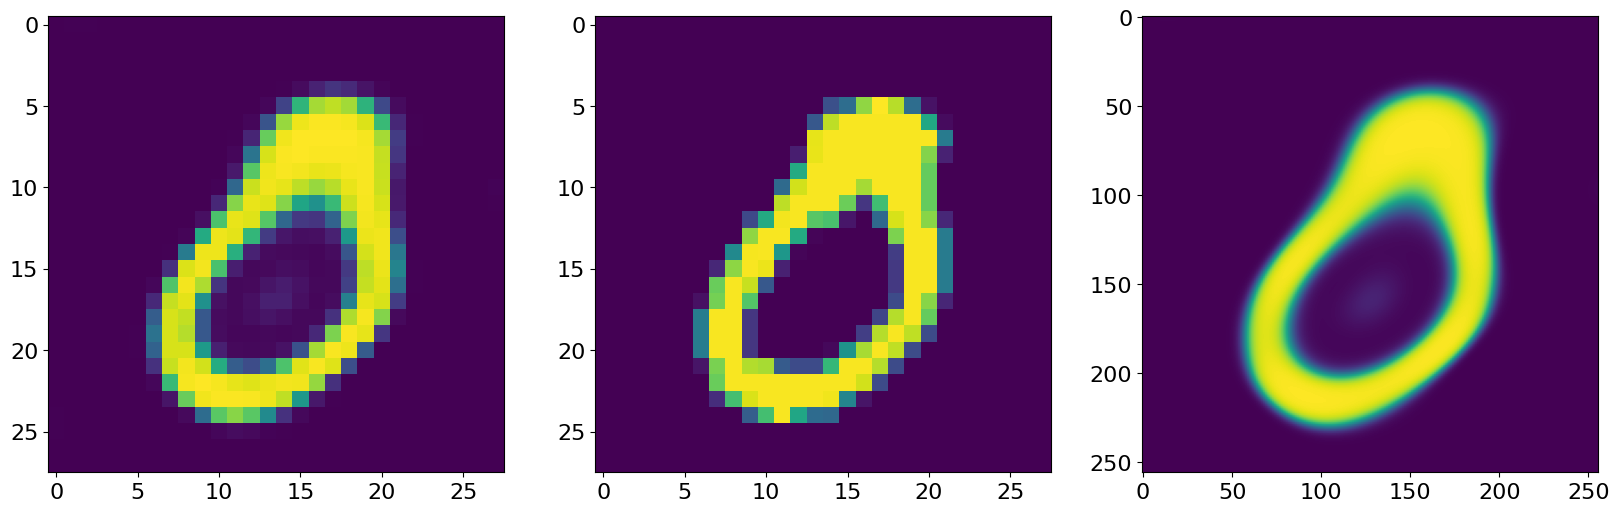

In [ ]:
plt.subplot(1,3,1)
plt.imshow(pap.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(papUp.reshape((256,256)))

## Gelu

In [ ]:
inputs=layers.Input(shape=( 2))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation='gelu')(inputs)
x2=layers.Dense(4, activation='gelu')(x1)
x=layers.Dense(1, activation='sigmoid')(x2)


mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_25 (Dense)            (None, 16)                48        
                                                                 
 dense_26 (Dense)            (None, 4)                 68        
                                                                 
 dense_27 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.2323 - accuracy: 0.2870
Epoch 2/1000
25/25 [==============================] - 0s 964us/step - loss: 0.2135 - accuracy: 0.7194
Epoch 3/1000
25/25 [==============================] - 0s 901us/step - loss: 0.1986 - accuracy: 0.7628
Epoch 4/1000
25/25 [==============================] - 0s 902us/step - loss: 0.1852 - accuracy: 0.7628
Epoch 5/1000
25/25 [==============================] - 0s 845us/step - loss: 0.1727 - accuracy: 0.7628
Epoch 6/1000
25/25 [==============================] - 0s 859us/step - loss: 0.1618 - accuracy: 0.7628
Epoch 7/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.1524 - accuracy: 0.7628
Epoch 8/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.1451 - accuracy: 0.7628
Epoch 9/1000
25/25 [==============================] - 0s 811us/step - loss: 0.1397 - accuracy: 0.7628
Epoch 10/1000
25/25 [==============================] - 0s 805us/step - loss: 0.1357 - ac

25/25 [==============================] - 0s 865us/step - loss: 0.0826 - accuracy: 0.7194
Epoch 81/1000
25/25 [==============================] - 0s 956us/step - loss: 0.0823 - accuracy: 0.7181
Epoch 82/1000
25/25 [==============================] - 0s 794us/step - loss: 0.0821 - accuracy: 0.7143
Epoch 83/1000
25/25 [==============================] - 0s 944us/step - loss: 0.0819 - accuracy: 0.7168
Epoch 84/1000
25/25 [==============================] - 0s 893us/step - loss: 0.0817 - accuracy: 0.7156
Epoch 85/1000
25/25 [==============================] - 0s 949us/step - loss: 0.0818 - accuracy: 0.7105
Epoch 86/1000
25/25 [==============================] - 0s 873us/step - loss: 0.0814 - accuracy: 0.7156
Epoch 87/1000
25/25 [==============================] - 0s 775us/step - loss: 0.0812 - accuracy: 0.7130
Epoch 88/1000
25/25 [==============================] - 0s 906us/step - loss: 0.0811 - accuracy: 0.7105
Epoch 89/1000
25/25 [==============================] - 0s 847us/step - loss: 0.0810 - a

25/25 [==============================] - 0s 957us/step - loss: 0.0777 - accuracy: 0.7092
Epoch 160/1000
25/25 [==============================] - 0s 861us/step - loss: 0.0778 - accuracy: 0.7092
Epoch 161/1000
25/25 [==============================] - 0s 864us/step - loss: 0.0777 - accuracy: 0.7105
Epoch 162/1000
25/25 [==============================] - 0s 745us/step - loss: 0.0775 - accuracy: 0.7092
Epoch 163/1000
25/25 [==============================] - 0s 852us/step - loss: 0.0776 - accuracy: 0.7092
Epoch 164/1000
25/25 [==============================] - 0s 874us/step - loss: 0.0774 - accuracy: 0.7092
Epoch 165/1000
25/25 [==============================] - 0s 855us/step - loss: 0.0774 - accuracy: 0.7117
Epoch 166/1000
25/25 [==============================] - 0s 888us/step - loss: 0.0773 - accuracy: 0.7117
Epoch 167/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.7092
Epoch 168/1000
25/25 [==============================] - 0s 964us/step - loss: 0.0

25/25 [==============================] - 0s 888us/step - loss: 0.0705 - accuracy: 0.7258
Epoch 239/1000
25/25 [==============================] - 0s 914us/step - loss: 0.0704 - accuracy: 0.7258
Epoch 240/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.7258
Epoch 241/1000
25/25 [==============================] - 0s 966us/step - loss: 0.0700 - accuracy: 0.7258
Epoch 242/1000
25/25 [==============================] - 0s 907us/step - loss: 0.0698 - accuracy: 0.7258
Epoch 243/1000
25/25 [==============================] - 0s 831us/step - loss: 0.0696 - accuracy: 0.7258
Epoch 244/1000
25/25 [==============================] - 0s 875us/step - loss: 0.0694 - accuracy: 0.7258
Epoch 245/1000
25/25 [==============================] - 0s 974us/step - loss: 0.0692 - accuracy: 0.7258
Epoch 246/1000
25/25 [==============================] - 0s 821us/step - loss: 0.0691 - accuracy: 0.7270
Epoch 247/1000
25/25 [==============================] - 0s 752us/step - loss: 0.0

25/25 [==============================] - 0s 1ms/step - loss: 0.0468 - accuracy: 0.7551
Epoch 318/1000
25/25 [==============================] - 0s 919us/step - loss: 0.0465 - accuracy: 0.7577
Epoch 319/1000
25/25 [==============================] - 0s 860us/step - loss: 0.0461 - accuracy: 0.7589
Epoch 320/1000
25/25 [==============================] - 0s 833us/step - loss: 0.0459 - accuracy: 0.7589
Epoch 321/1000
25/25 [==============================] - 0s 788us/step - loss: 0.0456 - accuracy: 0.7589
Epoch 322/1000
25/25 [==============================] - 0s 948us/step - loss: 0.0452 - accuracy: 0.7589
Epoch 323/1000
25/25 [==============================] - 0s 997us/step - loss: 0.0448 - accuracy: 0.7589
Epoch 324/1000
25/25 [==============================] - 0s 965us/step - loss: 0.0446 - accuracy: 0.7602
Epoch 325/1000
25/25 [==============================] - 0s 814us/step - loss: 0.0442 - accuracy: 0.7602
Epoch 326/1000
25/25 [==============================] - 0s 969us/step - loss: 0.0

25/25 [==============================] - 0s 803us/step - loss: 0.0316 - accuracy: 0.7615
Epoch 397/1000
25/25 [==============================] - 0s 912us/step - loss: 0.0314 - accuracy: 0.7615
Epoch 398/1000
25/25 [==============================] - 0s 887us/step - loss: 0.0313 - accuracy: 0.7615
Epoch 399/1000
25/25 [==============================] - 0s 888us/step - loss: 0.0311 - accuracy: 0.7615
Epoch 400/1000
25/25 [==============================] - 0s 921us/step - loss: 0.0308 - accuracy: 0.7615
Epoch 401/1000
25/25 [==============================] - 0s 800us/step - loss: 0.0306 - accuracy: 0.7615
Epoch 402/1000
25/25 [==============================] - 0s 981us/step - loss: 0.0303 - accuracy: 0.7615
Epoch 403/1000
25/25 [==============================] - 0s 831us/step - loss: 0.0302 - accuracy: 0.7615
Epoch 404/1000
25/25 [==============================] - 0s 838us/step - loss: 0.0300 - accuracy: 0.7615
Epoch 405/1000
25/25 [==============================] - 0s 858us/step - loss: 0

Epoch 475/1000
25/25 [==============================] - 0s 722us/step - loss: 0.0220 - accuracy: 0.7640
Epoch 476/1000
25/25 [==============================] - 0s 859us/step - loss: 0.0219 - accuracy: 0.7640
Epoch 477/1000
25/25 [==============================] - 0s 832us/step - loss: 0.0221 - accuracy: 0.7640
Epoch 478/1000
25/25 [==============================] - 0s 877us/step - loss: 0.0218 - accuracy: 0.7640
Epoch 479/1000
25/25 [==============================] - 0s 823us/step - loss: 0.0218 - accuracy: 0.7640
Epoch 480/1000
25/25 [==============================] - 0s 882us/step - loss: 0.0218 - accuracy: 0.7640
Epoch 481/1000
25/25 [==============================] - 0s 822us/step - loss: 0.0217 - accuracy: 0.7640
Epoch 482/1000
25/25 [==============================] - 0s 841us/step - loss: 0.0216 - accuracy: 0.7640
Epoch 483/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0215 - accuracy: 0.7640
Epoch 484/1000
25/25 [==============================] - 0s 908us/s

25/25 [==============================] - 0s 718us/step - loss: 0.0191 - accuracy: 0.7640
Epoch 554/1000
25/25 [==============================] - 0s 812us/step - loss: 0.0190 - accuracy: 0.7640
Epoch 555/1000
25/25 [==============================] - 0s 829us/step - loss: 0.0191 - accuracy: 0.7640
Epoch 556/1000
25/25 [==============================] - 0s 798us/step - loss: 0.0190 - accuracy: 0.7640
Epoch 557/1000
25/25 [==============================] - 0s 731us/step - loss: 0.0190 - accuracy: 0.7640
Epoch 558/1000
25/25 [==============================] - 0s 826us/step - loss: 0.0189 - accuracy: 0.7640
Epoch 559/1000
25/25 [==============================] - 0s 779us/step - loss: 0.0190 - accuracy: 0.7640
Epoch 560/1000
25/25 [==============================] - 0s 826us/step - loss: 0.0188 - accuracy: 0.7640
Epoch 561/1000
25/25 [==============================] - 0s 810us/step - loss: 0.0189 - accuracy: 0.7640
Epoch 562/1000
25/25 [==============================] - 0s 842us/step - loss: 0

25/25 [==============================] - 0s 801us/step - loss: 0.0174 - accuracy: 0.7640
Epoch 633/1000
25/25 [==============================] - 0s 873us/step - loss: 0.0175 - accuracy: 0.7640
Epoch 634/1000
25/25 [==============================] - 0s 926us/step - loss: 0.0175 - accuracy: 0.7640
Epoch 635/1000
25/25 [==============================] - 0s 787us/step - loss: 0.0174 - accuracy: 0.7640
Epoch 636/1000
25/25 [==============================] - 0s 866us/step - loss: 0.0173 - accuracy: 0.7640
Epoch 637/1000
25/25 [==============================] - 0s 726us/step - loss: 0.0173 - accuracy: 0.7640
Epoch 638/1000
25/25 [==============================] - 0s 792us/step - loss: 0.0174 - accuracy: 0.7640
Epoch 639/1000
25/25 [==============================] - 0s 783us/step - loss: 0.0173 - accuracy: 0.7640
Epoch 640/1000
25/25 [==============================] - 0s 843us/step - loss: 0.0173 - accuracy: 0.7640
Epoch 641/1000
25/25 [==============================] - 0s 840us/step - loss: 0

25/25 [==============================] - 0s 909us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 712/1000
25/25 [==============================] - 0s 950us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 713/1000
25/25 [==============================] - 0s 927us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 714/1000
25/25 [==============================] - 0s 849us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 715/1000
25/25 [==============================] - 0s 780us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 716/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 0.7640
Epoch 717/1000
25/25 [==============================] - 0s 732us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 718/1000
25/25 [==============================] - 0s 902us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 719/1000
25/25 [==============================] - 0s 767us/step - loss: 0.0163 - accuracy: 0.7640
Epoch 720/1000
25/25 [==============================] - 0s 840us/step - loss: 0.0

25/25 [==============================] - 0s 945us/step - loss: 0.0155 - accuracy: 0.7640
Epoch 791/1000
25/25 [==============================] - 0s 965us/step - loss: 0.0155 - accuracy: 0.7640
Epoch 792/1000
25/25 [==============================] - 0s 907us/step - loss: 0.0155 - accuracy: 0.7640
Epoch 793/1000
25/25 [==============================] - 0s 956us/step - loss: 0.0155 - accuracy: 0.7640
Epoch 794/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0159 - accuracy: 0.7640
Epoch 795/1000
25/25 [==============================] - 0s 853us/step - loss: 0.0155 - accuracy: 0.7640
Epoch 796/1000
25/25 [==============================] - 0s 937us/step - loss: 0.0158 - accuracy: 0.7640
Epoch 797/1000
25/25 [==============================] - 0s 898us/step - loss: 0.0155 - accuracy: 0.7640
Epoch 798/1000
25/25 [==============================] - 0s 965us/step - loss: 0.0156 - accuracy: 0.7640
Epoch 799/1000
25/25 [==============================] - 0s 800us/step - loss: 0.0

Epoch 869/1000
25/25 [==============================] - 0s 948us/step - loss: 0.0154 - accuracy: 0.7640
Epoch 870/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.7640
Epoch 871/1000
25/25 [==============================] - 0s 831us/step - loss: 0.0152 - accuracy: 0.7640
Epoch 872/1000
25/25 [==============================] - 0s 854us/step - loss: 0.0149 - accuracy: 0.7640
Epoch 873/1000
25/25 [==============================] - 0s 836us/step - loss: 0.0149 - accuracy: 0.7640
Epoch 874/1000
25/25 [==============================] - 0s 825us/step - loss: 0.0149 - accuracy: 0.7640
Epoch 875/1000
25/25 [==============================] - 0s 989us/step - loss: 0.0149 - accuracy: 0.7640
Epoch 876/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0149 - accuracy: 0.7640
Epoch 877/1000
25/25 [==============================] - 0s 989us/step - loss: 0.0149 - accuracy: 0.7640
Epoch 878/1000
25/25 [==============================] - 0s 813us/ste

25/25 [==============================] - 0s 918us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 948/1000
25/25 [==============================] - 0s 830us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 949/1000
25/25 [==============================] - 0s 869us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 950/1000
25/25 [==============================] - 0s 998us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 951/1000
25/25 [==============================] - 0s 880us/step - loss: 0.0144 - accuracy: 0.7640
Epoch 952/1000
25/25 [==============================] - 0s 877us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 953/1000
25/25 [==============================] - 0s 901us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 954/1000
25/25 [==============================] - 0s 845us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 955/1000
25/25 [==============================] - 0s 853us/step - loss: 0.0143 - accuracy: 0.7640
Epoch 956/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0

In [ ]:
pop=mlp.predict(coords)


25/25 [==============================] - 0s 370us/step


25/25 [==============================] - 0s 456us/step


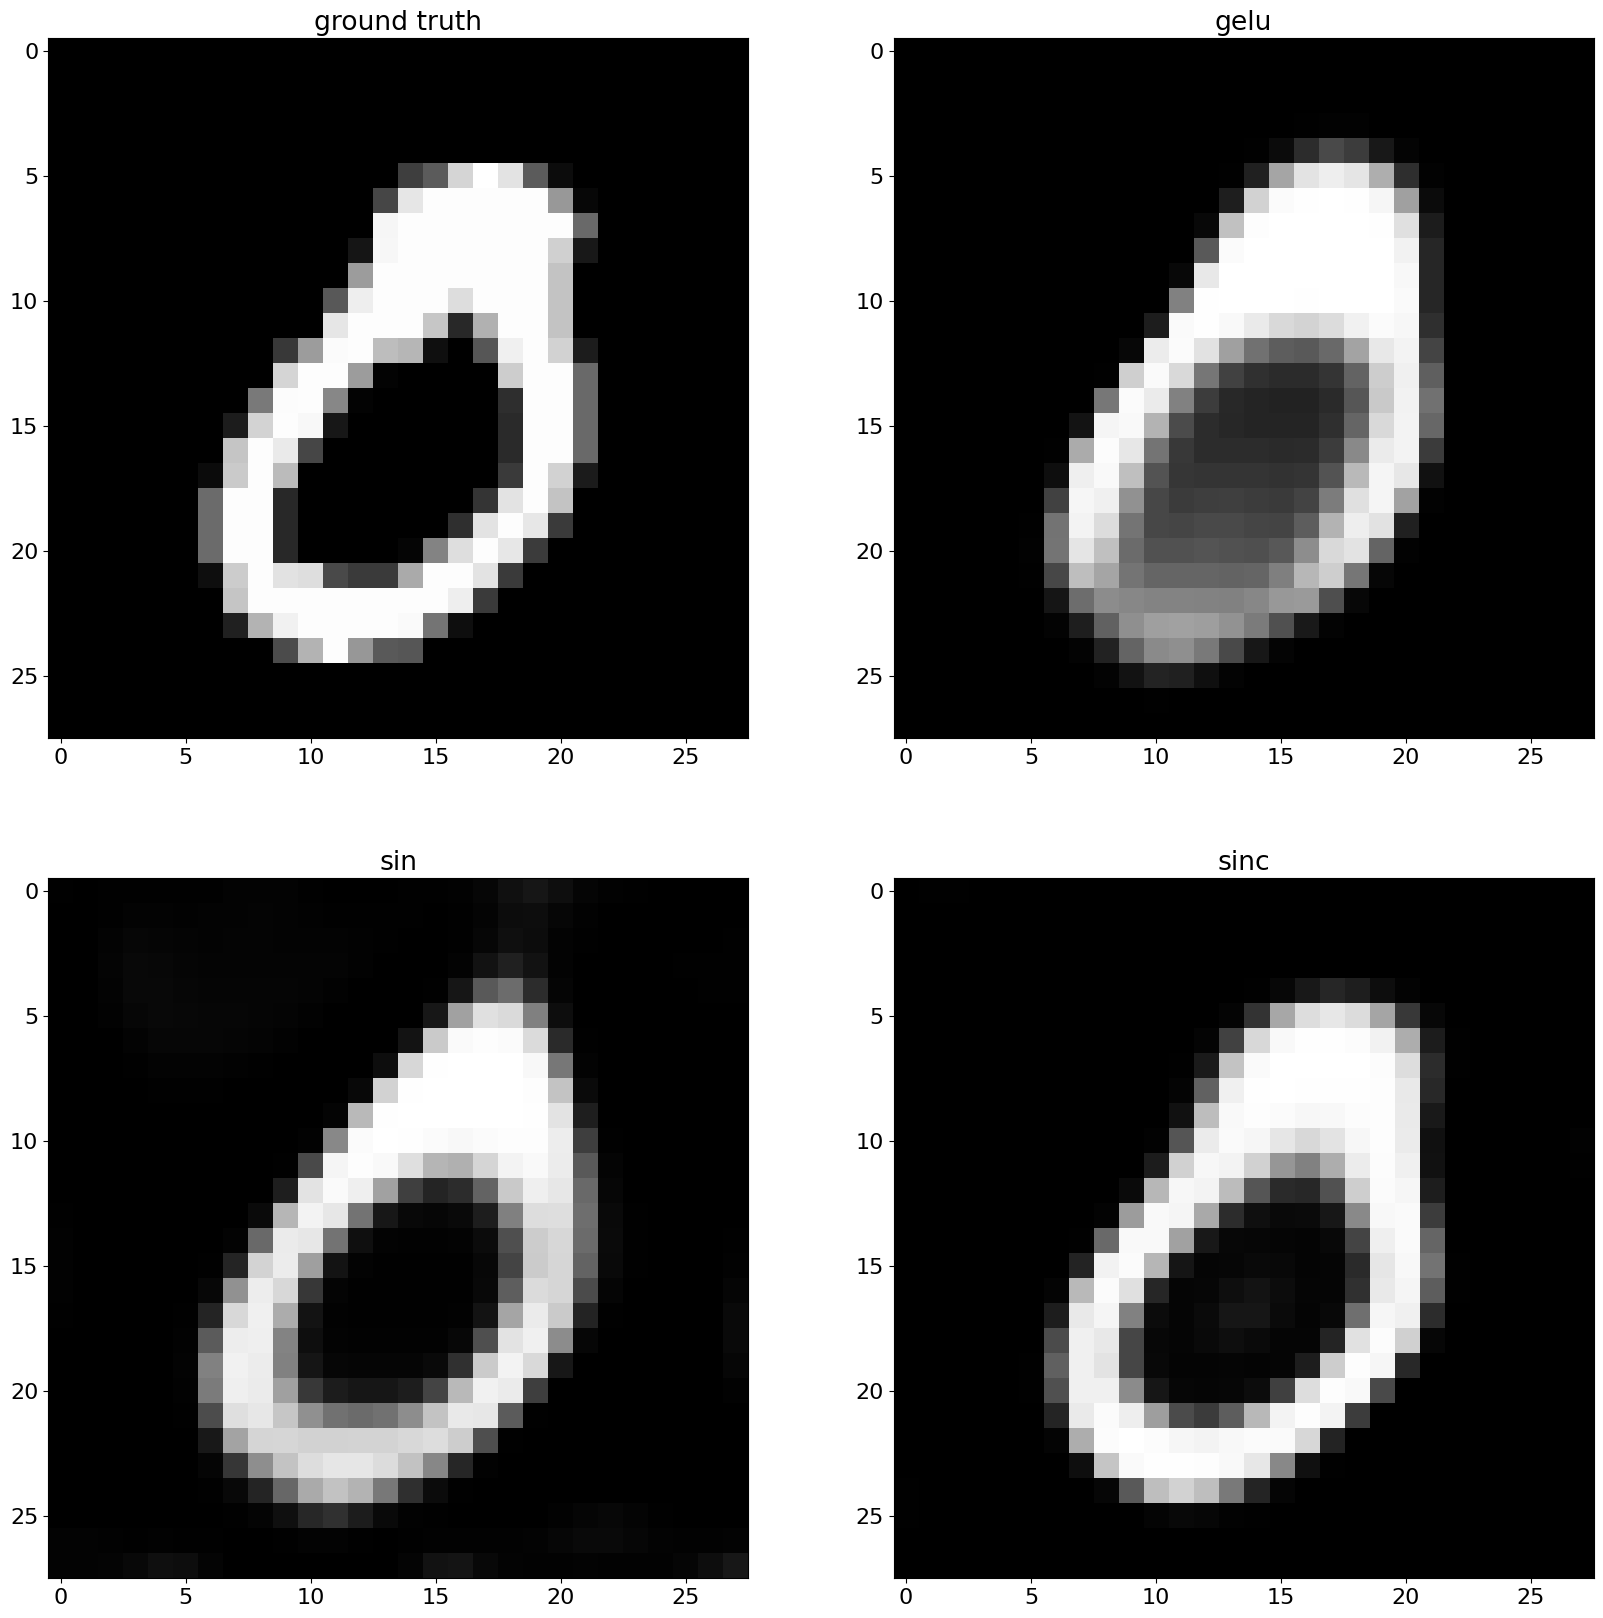

In [ ]:
plt.figure(figsize=(20,20))
pop=mlp.predict(coords)
plt.subplot(2,2,1)
plt.imshow(pixels.reshape((28,28)), cmap='gray')
plt.title('ground truth')
plt.subplot(2,2,2)
plt.imshow(pop.reshape((28,28)), cmap='gray')
plt.title('gelu')
plt.subplot(2,2,3)
plt.imshow(pip.reshape((28,28)), cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
plt.imshow(pap.reshape((28,28)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNR.pdf')



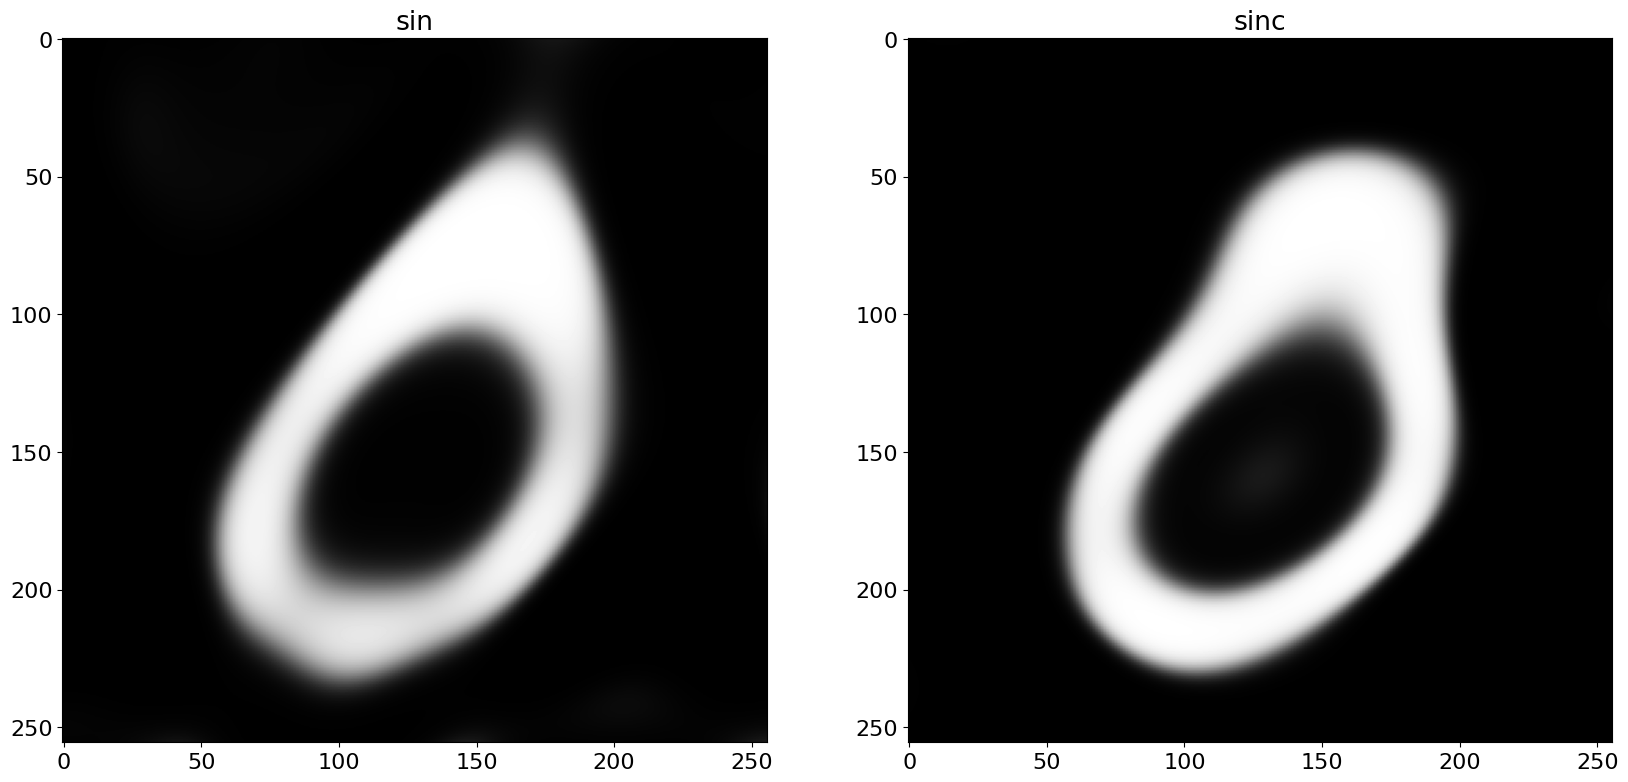

In [ ]:
plt.subplot(1,2,1)
plt.imshow(pipUp.reshape((256,256)), cmap='gray')
plt.title('sin')
plt.subplot(1,2,2)
plt.imshow(papUp.reshape((256,256)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNRup.pdf')